<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6 - Tree-based Methods

### Author: Gloria Rivas

##**Formulation Analysis**
----
Let´s compare local RSS minimization, RSS gain maximization, and total RSS minimization in detail.

- The first question we will answer is: **Are local RSS minimization and RSS gain maximization equivalent?**

1. Local RSS Minimization:
Choose the split
$(X_j,t)$ that minimizes:
$$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$
2. RSS Gain Maximization:
Choose the split
$(X_j,t)$ that maximizes:
$$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Children RSS}}
   \Bigr\}.
   $$

These are mathematically equivalent, because:

$$argmax(Parent RSS−Children RSS)=argmin(Children RSS)$$

The parent RSS does not depend on the split, so maximizing the gain is the same as minimizing the children RSS.

- Now, let's go into the second question:   **Does *total RSS minimization* coincide with either of these two, or is it distinct?**

3. Total RSS Minimization: Choose the split
$(X_j,t)$ that minimizes:
$$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))}
   \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2,
   $$
   where
   $$
   \overline{y}_{R_m} = \frac{1}{\lvert R_m \rvert}
   \sum_{i \in R_m} y_i
   $$
   is the mean response in leaf $m$.

So we have that in the context of greedy tree growing, where only one leaf is split at a time, the total RSS reduces to:

$$Old Total RSS=RSS of current leaf+RSS of other unchanged leaves$$
$$New Total RSS
=
RSS of left child
+
RSS of right child
+
RSS of other unchanged leaves$$

Since the "other leaves" are unchanged, minimizing Total RSS is equivalent to minimizing:

$$RSS
left
+
RSS
right$$

Therefore, in greedy algorithms like CART("It works by recursively partitioning the data based on the most informative features"), Total RSS Minimization behaves exactly like Local RSS Minimization.

However, in global optimization they might be cases when the Total RSS would give different results. A counterexample would be having two candidate leaves A and B to split and knowing that splitting A gives a local gain of 50, and splitting B gives a gain of 40, but opens opportunities for higher benefits later.
In a global view (Total RSS), splitting B might lead to a better tree long-term.

Conclusively, the answer to the question is no, Total RSS is a distinct measure in general, as it considers futher away benefits.

##**Empirical Experiment**
We want to determine which of the previous 3 formulations is used by scikit-learn's DecisionTreeRegressor. In order to do this, we created a very small dataset with the following values:
X = [1, 2, 3, 10, 11, 12, 13]
y = [1, 1, 6, 3, 3, 9, 9]
A greedy algorithm searchs for local benefits so sees high gain by splitting off [9, 9] from the rest (X > 11.5)

Now left side has:
1,2,3,10,11 → y = 1,1,6,3,3
Splits again at X = 2.5 to isolate [1, 1]
This are all local decisions.
- What would a global algorithm do instead?
<br>Split at X = 11 (between X = 11 and X = 12)
Left: X = [10, 11] → y = [3, 3]. Right: X = [12, 13] → y = [9, 9].
This gives two pure groups (RSS = 0 on both sides) and leaves the left part
[1,2,3] untouched (which has lower RSS than mixed group 1,2,3,10,11).

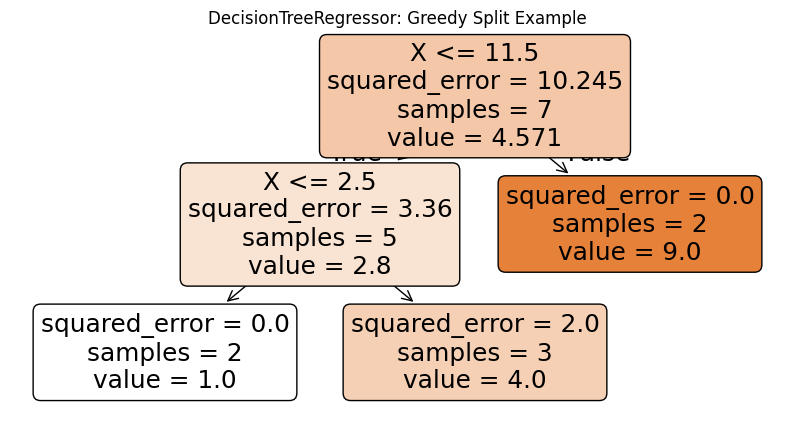

Tree Splits:
    Node  Feature Index  Threshold
0     0              0       11.5
1     1              0        2.5

Predictions and Leaf Assignments:
     X  y  Predicted y  Leaf Node
0   1  1          1.0          2
1   2  1          1.0          2
2   3  6          4.0          3
3  10  3          4.0          3
4  11  3          4.0          3
5  12  9          9.0          4
6  13  9          9.0          4

Manual RSS Comparison:
            Split Option  Local Gain  Total RSS After Split
0  Split A (local best)   16.666667              36.000000
1  Split B (total best)   36.000000              16.666667


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree


X_A = np.array([[1], [2], [3]])
y_A = np.array([1, 1, 6])

X_B = np.array([[10], [11], [12], [13]])
y_B = np.array([3, 3, 9, 9])

X = np.vstack((X_A, X_B))
y = np.concatenate((y_A, y_B))

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X, y)

plt.figure(figsize=(10, 5))
plot_tree(tree, feature_names=["X"], filled=True, rounded=True)
plt.title("DecisionTreeRegressor: Greedy Split Example")
plt.show()

thresholds = tree.tree_.threshold
features = tree.tree_.feature
split_info = pd.DataFrame({
    "Node": np.arange(len(thresholds)),
    "Feature Index": features,
    "Threshold": thresholds
})
split_info = split_info[split_info["Threshold"] != -2]
print("Tree Splits:\n", split_info)

leaf_nodes = tree.apply(X)
predictions = tree.predict(X)
results = pd.DataFrame({
    "X": X.flatten(),
    "y": y,
    "Predicted y": predictions,
    "Leaf Node": leaf_nodes
}).sort_values("X")
print("\nPredictions and Leaf Assignments:\n", results)


def rss(y_vals):
    return np.sum((y_vals - np.mean(y_vals)) ** 2)

rss_A = rss(y_A)
rss_B = rss(y_B)
total_rss_before = rss_A + rss_B

# Split A: split Leaf A into [1, 1] and [6]
rss_A_left = rss(np.array([1, 1]))
rss_A_right = rss(np.array([6]))
rss_A_after = rss_A_left + rss_A_right
total_rss_A_split = rss_A_after + rss_B
gain_A = rss_A - rss_A_after

# Split B: split Leaf B into [3, 3] and [9, 9]
rss_B_left = rss(np.array([3, 3]))
rss_B_right = rss(np.array([9, 9]))
rss_B_after = rss_B_left + rss_B_right
total_rss_B_split = rss_A + rss_B_after
gain_B = rss_B - rss_B_after

comparison = pd.DataFrame({
    "Split Option": ["Split A (local best)", "Split B (total best)"],
    "Local Gain": [gain_A, gain_B],
    "Total RSS After Split": [total_rss_A_split, total_rss_B_split]
})

print("\nManual RSS Comparison:\n", comparison)


**Conclusion**
<br>This behavior confirms that DecisionTreeRegressor implements a greedy algorithm, using Local RSS Minimization (equivalent to maximizing RSS Gain at each split), and does not globally minimize total RSS (does not use total RSS minimization formulation).